In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc

**Load and normalize the data**

In [3]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [5]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [6]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [7]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [8]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **Resnet**

In [8]:
model_temp = 'resnet_pret'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [06:30<00:00, 262kB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [11]:
start_time = time.time()

In [12]:
epochs = 30
patience = 5
model_filename = 'resnet_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:33<45:23, 93.90s/it]

Epoch 1
Training Loss: 1.1297600141483375 
Training Accuracy: 58.340074421614624%
Validation Loss: 0.9332314684255487 
Validation Accuracy: 66.72868467885455%
Validation Loss Decreased(inf--->0.933231) 
Saving The Model


  7%|▋         | 2/30 [03:04<42:57, 92.04s/it]

Epoch 2
Training Loss: 0.7829146582334848 
Training Accuracy: 71.37194628700857%
Validation Loss: 0.7424583478183401 
Validation Accuracy: 72.77948552014237%
Validation Loss Decreased(0.933231--->0.742458) 
Saving The Model


 10%|█         | 3/30 [04:38<41:45, 92.81s/it]

Epoch 3
Training Loss: 0.6490952488833928 
Training Accuracy: 76.01520789516259%
Validation Loss: 0.6857930155379519 
Validation Accuracy: 74.28409642452678%
Validation Loss Decreased(0.742458--->0.685793) 
Saving The Model


 13%|█▎        | 4/30 [06:07<39:38, 91.50s/it]

Epoch 4
Training Loss: 0.554627937132382 
Training Accuracy: 80.05986086393787%
Validation Loss: 0.5841291674655845 
Validation Accuracy: 78.28021355767675%
Validation Loss Decreased(0.685793--->0.584129) 
Saving The Model


 17%|█▋        | 5/30 [07:42<38:37, 92.69s/it]

Epoch 5
Training Loss: 0.48339108495133176 
Training Accuracy: 82.47047403332795%
Validation Loss: 0.4923971892173284 
Validation Accuracy: 81.83141886426145%
Validation Loss Decreased(0.584129--->0.492397) 
Saving The Model


 20%|██        | 6/30 [09:16<37:10, 92.96s/it]

Epoch 6
Training Loss: 0.4264645477521019 
Training Accuracy: 84.54942565927844%
Validation Loss: 0.44913595321874594 
Validation Accuracy: 82.88302863614302%
Validation Loss Decreased(0.492397--->0.449136) 
Saving The Model


 23%|██▎       | 7/30 [10:52<36:03, 94.07s/it]

Epoch 7
Training Loss: 0.3825332380118912 
Training Accuracy: 86.32907296553955%
Validation Loss: 0.3833759288840208 
Validation Accuracy: 86.70118103866689%
Validation Loss Decreased(0.449136--->0.383376) 
Saving The Model


 27%|██▋       | 8/30 [12:27<34:38, 94.49s/it]

Epoch 8
Training Loss: 0.32911625593053584 
Training Accuracy: 88.29477430836434%
Validation Loss: 0.31783861716973383 
Validation Accuracy: 88.67497168742922%
Validation Loss Decreased(0.383376--->0.317839) 
Saving The Model


 30%|███       | 9/30 [13:57<32:35, 93.11s/it]

Epoch 9
Training Loss: 0.3095474177706765 
Training Accuracy: 89.25740171493285%
Validation Loss: 0.306206900626421 
Validation Accuracy: 88.95809739524348%
Validation Loss Decreased(0.317839--->0.306207) 
Saving The Model


 33%|███▎      | 10/30 [15:27<30:42, 92.12s/it]

Epoch 10
Training Loss: 0.2792617889164492 
Training Accuracy: 90.29283287493934%
Validation Loss: 0.24528806040530365 
Validation Accuracy: 91.47387154182171%
Validation Loss Decreased(0.306207--->0.245288) 
Saving The Model


 37%|███▋      | 11/30 [17:00<29:14, 92.37s/it]

Epoch 11
Training Loss: 0.25875939339283827 
Training Accuracy: 90.68920886587931%
Validation Loss: 0.2182620304951911 
Validation Accuracy: 92.14528393463841%
Validation Loss Decreased(0.245288--->0.218262) 
Saving The Model


 40%|████      | 12/30 [18:35<27:52, 92.93s/it]

Epoch 12
Training Loss: 0.23365316752739038 
Training Accuracy: 91.57903251900987%
Validation Loss: 0.22256857897961171 
Validation Accuracy: 92.25044491182656%


 43%|████▎     | 13/30 [20:12<26:43, 94.35s/it]

Epoch 13
Training Loss: 0.20970705547670832 
Training Accuracy: 92.71153535026694%
Validation Loss: 0.27813740653161545 
Validation Accuracy: 90.41417246400259%


 47%|████▋     | 14/30 [21:52<25:37, 96.07s/it]

Epoch 14
Training Loss: 0.20712808095091997 
Training Accuracy: 93.01892897589387%
Validation Loss: 0.3263521644717578 
Validation Accuracy: 89.40300922180877%


 50%|█████     | 15/30 [23:25<23:44, 95.00s/it]

Epoch 15
Training Loss: 0.191568388711921 
Training Accuracy: 93.39912635495874%
Validation Loss: 0.16286839744273468 
Validation Accuracy: 94.2565927843391%
Validation Loss Decreased(0.218262--->0.162868) 
Saving The Model


 53%|█████▎    | 16/30 [24:56<21:53, 93.84s/it]

Epoch 16
Training Loss: 0.16325113683630946 
Training Accuracy: 94.49927196246563%
Validation Loss: 0.16687133170673937 
Validation Accuracy: 94.29703931402686%


 57%|█████▋    | 17/30 [26:39<20:54, 96.51s/it]

Epoch 17
Training Loss: 0.140145613268037 
Training Accuracy: 95.26775602653292%
Validation Loss: 0.15724887970103388 
Validation Accuracy: 94.64487946934153%
Validation Loss Decreased(0.162868--->0.157249) 
Saving The Model


 60%|██████    | 18/30 [28:15<19:18, 96.56s/it]

Epoch 18
Training Loss: 0.15918876288473144 
Training Accuracy: 94.50736126840317%
Validation Loss: 0.1658042448895288 
Validation Accuracy: 94.52353988027828%


 63%|██████▎   | 19/30 [29:49<17:33, 95.79s/it]

Epoch 19
Training Loss: 0.13466958915790692 
Training Accuracy: 95.25157741465782%
Validation Loss: 0.15534257624919215 
Validation Accuracy: 94.87138003559295%
Validation Loss Decreased(0.157249--->0.155343) 
Saving The Model


 67%|██████▋   | 20/30 [31:24<15:53, 95.35s/it]

Epoch 20
Training Loss: 0.11985045003654189 
Training Accuracy: 95.87445397184922%
Validation Loss: 0.1842342568056066 
Validation Accuracy: 93.65798414496037%


 70%|███████   | 21/30 [33:03<14:29, 96.58s/it]

Epoch 21
Training Loss: 0.12530974910332213 
Training Accuracy: 95.76120368872351%
Validation Loss: 0.11509606589169726 
Validation Accuracy: 96.32745510435204%
Validation Loss Decreased(0.155343--->0.115096) 
Saving The Model


 73%|███████▎  | 22/30 [34:35<12:41, 95.24s/it]

Epoch 22
Training Loss: 0.12936616081561536 
Training Accuracy: 95.41336353340883%
Validation Loss: 0.14914595384092988 
Validation Accuracy: 95.00080893059375%


 77%|███████▋  | 23/30 [36:13<11:11, 95.99s/it]

Epoch 23
Training Loss: 0.10509984201128361 
Training Accuracy: 96.34363371622715%
Validation Loss: 0.15679137300440046 
Validation Accuracy: 94.63679016340399%


 80%|████████  | 24/30 [37:53<09:43, 97.31s/it]

Epoch 24
Training Loss: 0.10537909808898349 
Training Accuracy: 96.29509788060184%
Validation Loss: 0.11922359052390938 
Validation Accuracy: 96.32745510435204%


 83%|████████▎ | 25/30 [39:42<08:23, 100.77s/it]

Epoch 25
Training Loss: 0.09165298663325204 
Training Accuracy: 96.86943860216793%
Validation Loss: 0.13498953196944463 
Validation Accuracy: 95.80165021841125%


100%|██████████| 30/30 [41:20<00:00, 82.69s/it] 

Epoch 26
Training Loss: 0.08967714323433602 
Training Accuracy: 96.82899207248018%
Validation Loss: 0.1514947659676553 
Validation Accuracy: 95.0897912959068%


In [13]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 45.04 minutes


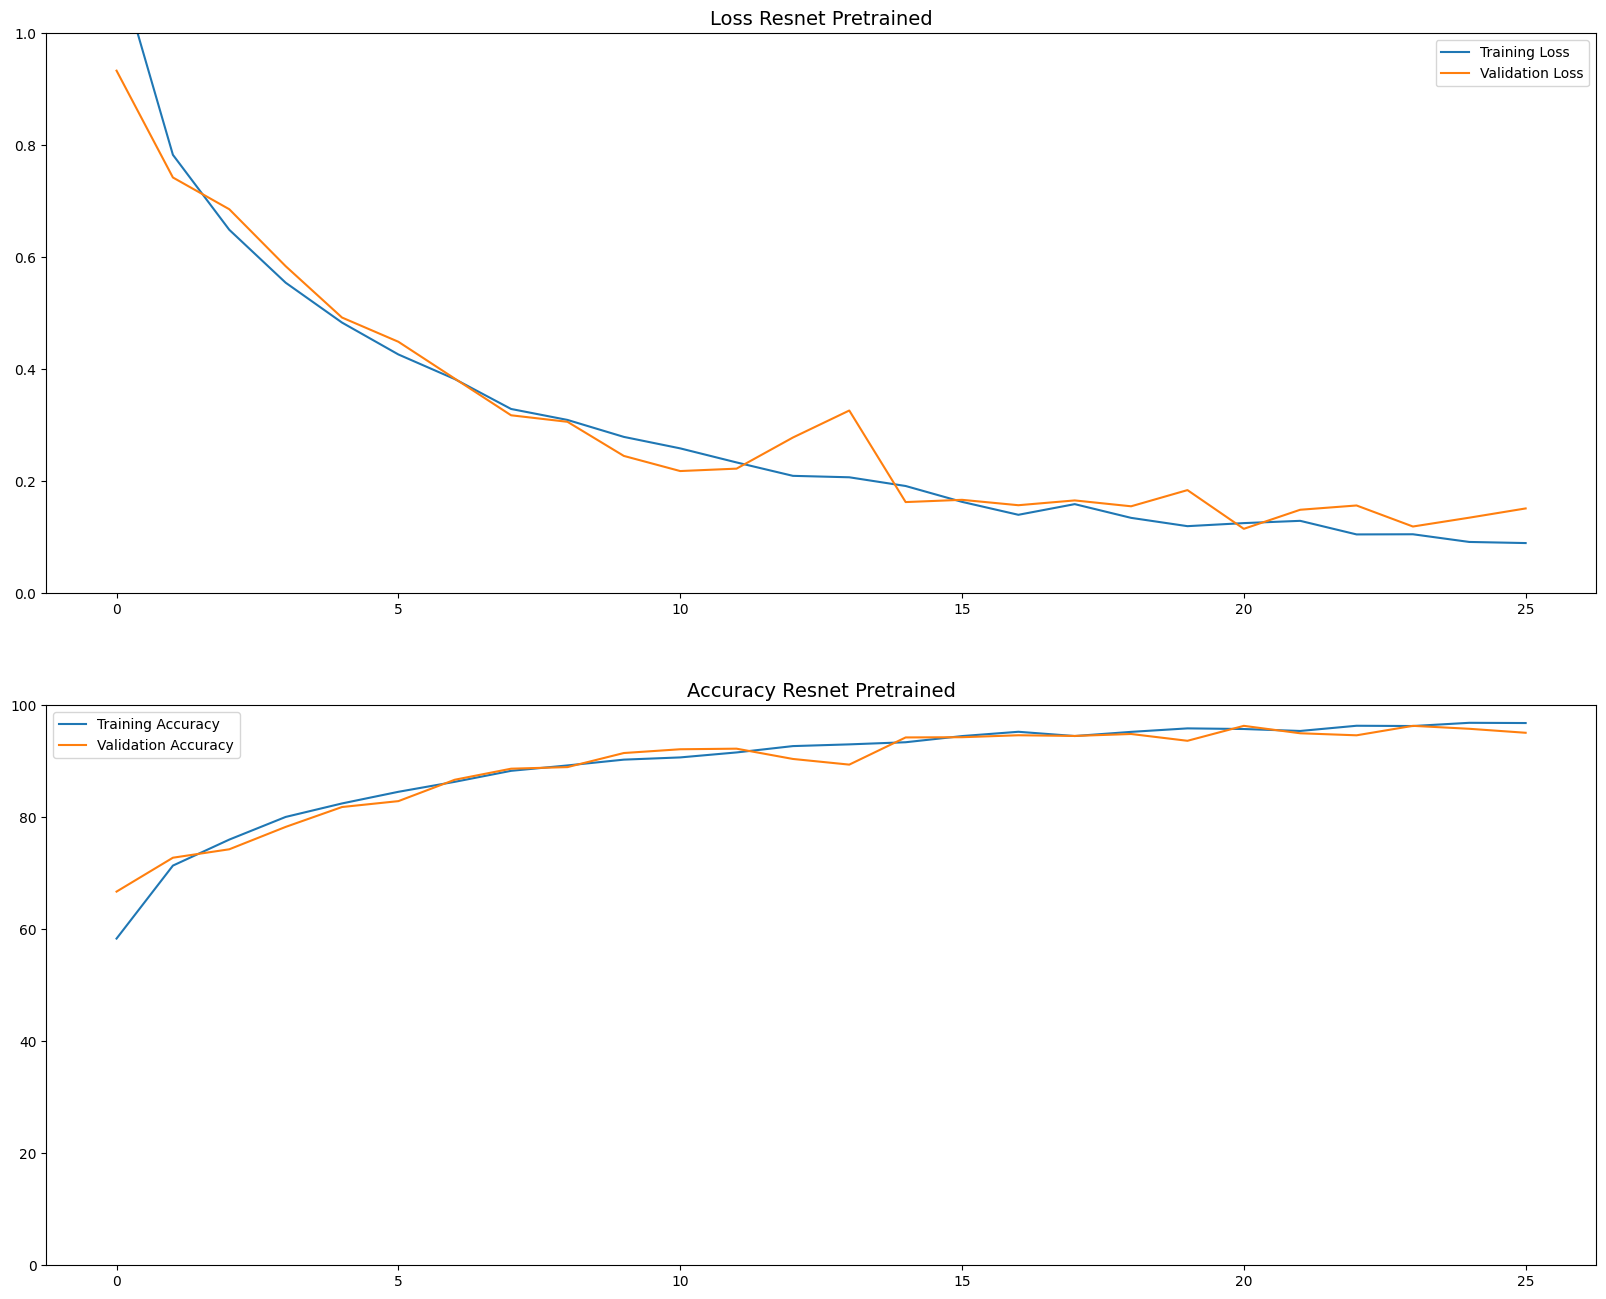

In [14]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [15]:
best_model_state = torch.load('resnet_pret.pth', map_location='cpu')
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(model_res, test_loader, device)

print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print('-------------------------------------------------------')


-------------------------------------------------------
Best model's accuracy: 96.61867011810386
-------------------------------------------------------


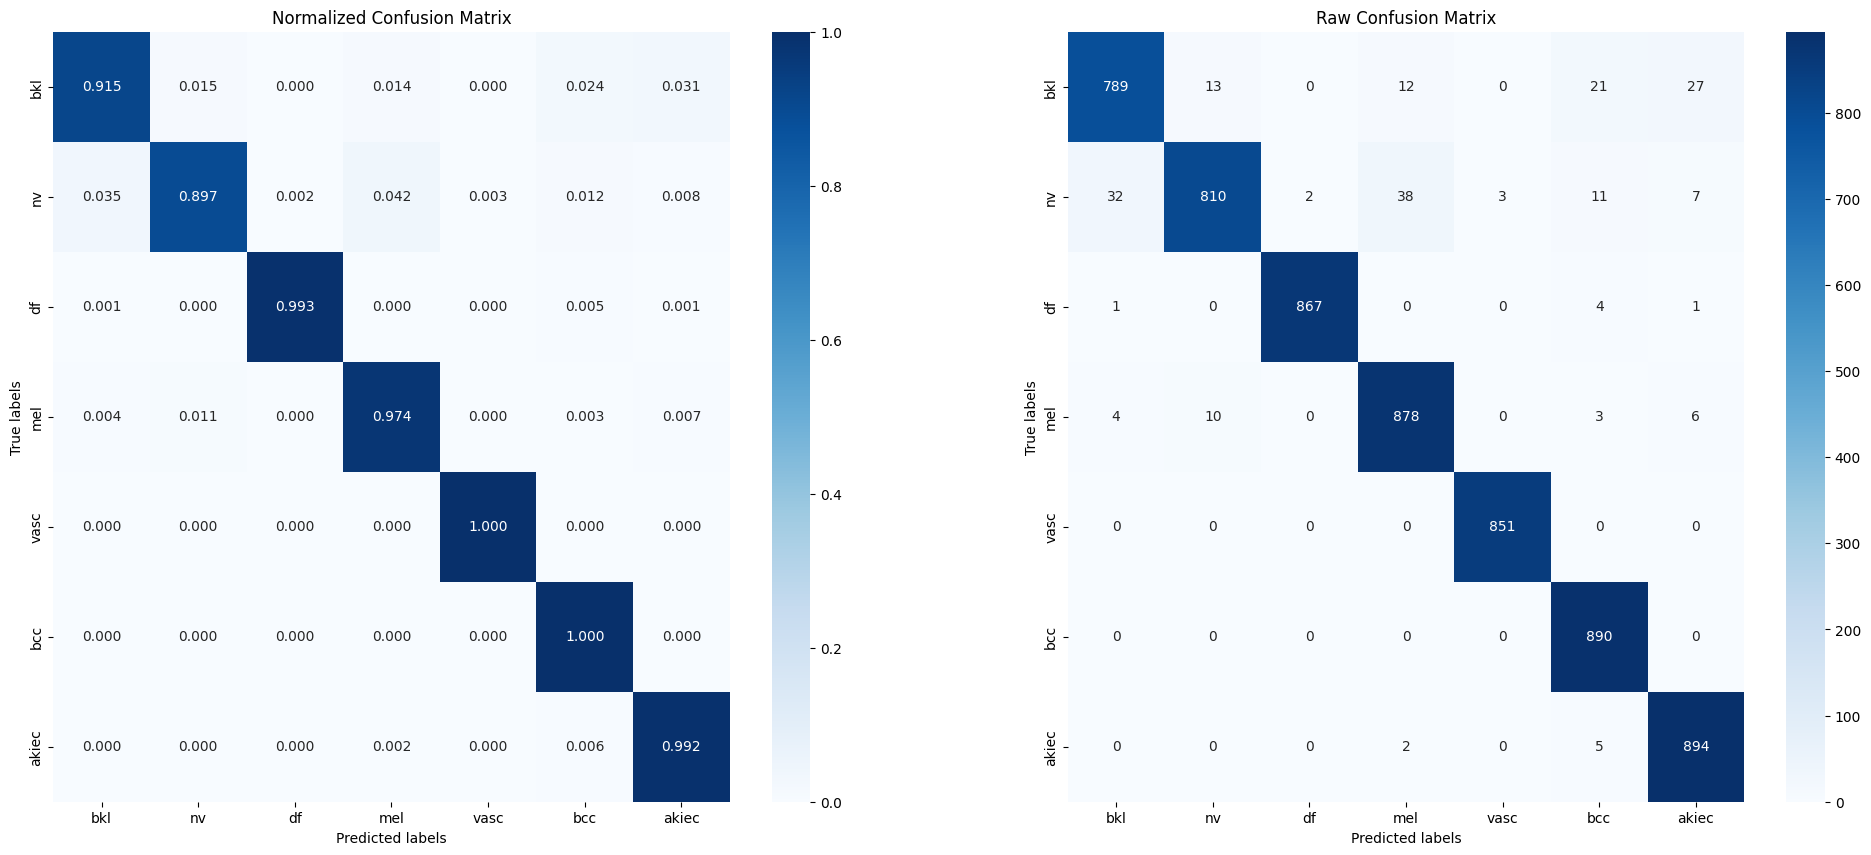

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.96      0.92      0.93       862
          nv       0.97      0.90      0.93       903
          df       1.00      0.99      1.00       873
         mel       0.94      0.97      0.96       901
        vasc       1.00      1.00      1.00       851
         bcc       0.95      1.00      0.98       890
       akiec       0.96      0.99      0.97       901

    accuracy                           0.97      6181
   macro avg       0.97      0.97      0.97      6181
weighted avg       0.97      0.97      0.97      6181

-------------------------------------------------------


In [16]:
Model_functions.conf_report(model_res, test_loader, 'resnet_conf_mat')

**Empty the CUDA memory**

In [36]:
torch.cuda.empty_cache() 
gc.collect()

28172

In [31]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **Densenet**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [11]:
model_temp = 'densenet_pret'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [13]:
input_size = (3, 224, 224)
print(summary(model_des, input_size, device=device.type))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28

In [14]:
start_time = time.time()

In [15]:
epochs = 30
patience = 5
model_filename = 'densenet_pret.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:32<44:43, 92.55s/it]

Epoch 1
Training Loss: 0.8603508583334989 
Training Accuracy: 68.46788545542792%
Validation Loss: 0.7718686659360733 
Validation Accuracy: 71.80067950169875%
Validation Loss Decreased(inf--->0.771869) 
Saving The Model


  7%|▋         | 2/30 [03:10<44:37, 95.63s/it]

Epoch 2
Training Loss: 0.5591774330659738 
Training Accuracy: 79.62303834331014%
Validation Loss: 0.5279756825253636 
Validation Accuracy: 80.61802297362887%
Validation Loss Decreased(0.771869--->0.527976) 
Saving The Model


 10%|█         | 3/30 [04:45<42:51, 95.23s/it]

Epoch 3
Training Loss: 0.4440142283220932 
Training Accuracy: 83.99126354958744%
Validation Loss: 0.45943564153456873 
Validation Accuracy: 83.53826241708461%
Validation Loss Decreased(0.527976--->0.459436) 
Saving The Model


 13%|█▎        | 4/30 [06:22<41:38, 96.08s/it]

Epoch 4
Training Loss: 0.36489988116484895 
Training Accuracy: 87.22698592460767%
Validation Loss: 0.4154176856619751 
Validation Accuracy: 85.15612360459473%
Validation Loss Decreased(0.459436--->0.415418) 
Saving The Model


 17%|█▋        | 5/30 [08:04<40:59, 98.40s/it]

Epoch 5
Training Loss: 0.3247386783322931 
Training Accuracy: 88.37566736773985%
Validation Loss: 0.3058586654756266 
Validation Accuracy: 89.32211616243326%
Validation Loss Decreased(0.415418--->0.305859) 
Saving The Model


 20%|██        | 6/30 [09:46<39:46, 99.42s/it]

Epoch 6
Training Loss: 0.27334222743331 
Training Accuracy: 90.35754732243973%
Validation Loss: 0.35471741025376996 
Validation Accuracy: 87.94693415304967%


 23%|██▎       | 7/30 [11:22<37:39, 98.24s/it]

Epoch 7
Training Loss: 0.24479797250983482 
Training Accuracy: 91.30399611713315%
Validation Loss: 0.2184509260613635 
Validation Accuracy: 92.26662352370167%
Validation Loss Decreased(0.305859--->0.218451) 
Saving The Model


 27%|██▋       | 8/30 [13:02<36:14, 98.84s/it]

Epoch 8
Training Loss: 0.20528061758697957 
Training Accuracy: 92.63873159682899%
Validation Loss: 0.19808212269665504 
Validation Accuracy: 93.25351884808283%
Validation Loss Decreased(0.218451--->0.198082) 
Saving The Model


 30%|███       | 9/30 [14:36<34:02, 97.28s/it]

Epoch 9
Training Loss: 0.19745858019405557 
Training Accuracy: 93.18880440058243%
Validation Loss: 0.16816697118067464 
Validation Accuracy: 94.42646820902766%
Validation Loss Decreased(0.198082--->0.168167) 
Saving The Model


 33%|███▎      | 10/30 [16:11<32:15, 96.77s/it]

Epoch 10
Training Loss: 0.1762159792922957 
Training Accuracy: 93.90066332308687%
Validation Loss: 0.26387633503599994 
Validation Accuracy: 90.5759585827536%


 37%|███▋      | 11/30 [17:53<31:10, 98.43s/it]

Epoch 11
Training Loss: 0.1624657727238898 
Training Accuracy: 94.52353988027828%
Validation Loss: 0.19462446312513926 
Validation Accuracy: 93.79550234589873%


 40%|████      | 12/30 [19:38<30:07, 100.43s/it]

Epoch 12
Training Loss: 0.15052963681615292 
Training Accuracy: 94.86329072965539%
Validation Loss: 0.19050862743983704 
Validation Accuracy: 93.63371622714772%


 43%|████▎     | 13/30 [21:28<29:12, 103.11s/it]

Epoch 13
Training Loss: 0.1261962614833192 
Training Accuracy: 95.60750687591005%
Validation Loss: 0.18770321366528786 
Validation Accuracy: 94.45073612684031%


 47%|████▋     | 14/30 [23:06<27:07, 101.75s/it]

Epoch 14
Training Loss: 0.13109608415095497 
Training Accuracy: 95.7450250768484%
Validation Loss: 0.10394772993838679 
Validation Accuracy: 96.57013428247856%
Validation Loss Decreased(0.168167--->0.103948) 
Saving The Model


 50%|█████     | 15/30 [24:55<25:56, 103.75s/it]

Epoch 15
Training Loss: 0.1106286000361719 
Training Accuracy: 96.19802620935124%
Validation Loss: 0.11144932935697818 
Validation Accuracy: 96.56204497654102%


 53%|█████▎    | 16/30 [26:27<23:24, 100.29s/it]

Epoch 16
Training Loss: 0.10916577023995477 
Training Accuracy: 96.2870085746643%
Validation Loss: 0.17058448164268983 
Validation Accuracy: 94.34557514965216%


 57%|█████▋    | 17/30 [28:08<21:44, 100.35s/it]

Epoch 17
Training Loss: 0.11175164637981266 
Training Accuracy: 96.13331176185083%
Validation Loss: 0.18966487056734546 
Validation Accuracy: 94.40220029121501%


 60%|██████    | 18/30 [29:46<19:56, 99.73s/it] 

Epoch 18
Training Loss: 0.09702123648869668 
Training Accuracy: 96.58631289435367%
Validation Loss: 0.07888668387808213 
Validation Accuracy: 97.65410127811033%
Validation Loss Decreased(0.103948--->0.078887) 
Saving The Model


 63%|██████▎   | 19/30 [31:26<18:19, 99.91s/it]

Epoch 19
Training Loss: 0.10668203414289054 
Training Accuracy: 96.3679016340398%
Validation Loss: 0.10220106351742815 
Validation Accuracy: 96.98268888529364%


 67%|██████▋   | 20/30 [33:19<17:19, 103.93s/it]

Epoch 20
Training Loss: 0.07892059472669878 
Training Accuracy: 97.29817181685812%
Validation Loss: 0.068188246722948 
Validation Accuracy: 97.89678045623685%
Validation Loss Decreased(0.078887--->0.068188) 
Saving The Model


 70%|███████   | 21/30 [35:00<15:26, 102.91s/it]

Epoch 21
Training Loss: 0.08467933081683958 
Training Accuracy: 97.31435042873322%
Validation Loss: 0.13960654628571384 
Validation Accuracy: 95.78547160653616%


 73%|███████▎  | 22/30 [36:34<13:22, 100.28s/it]

Epoch 22
Training Loss: 0.0970409122727046 
Training Accuracy: 96.83708137841774%
Validation Loss: 0.10552378524442561 
Validation Accuracy: 96.95842096748099%


 77%|███████▋  | 23/30 [38:10<11:32, 98.91s/it] 

Epoch 23
Training Loss: 0.07338972348862421 
Training Accuracy: 97.57320821873483%
Validation Loss: 0.07895556162111461 
Validation Accuracy: 97.69454780779809%


 80%|████████  | 24/30 [39:54<10:03, 100.59s/it]

Epoch 24
Training Loss: 0.084556556929466 
Training Accuracy: 97.16065361591976%
Validation Loss: 0.10148916757775071 
Validation Accuracy: 97.11211778029445%


100%|██████████| 30/30 [41:30<00:00, 83.03s/it] 

Epoch 25
Training Loss: 0.060154502776250465 
Training Accuracy: 98.02620935123767%
Validation Loss: 0.08096481068875762 
Validation Accuracy: 97.59747613654748%


In [16]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 55.85 minutes


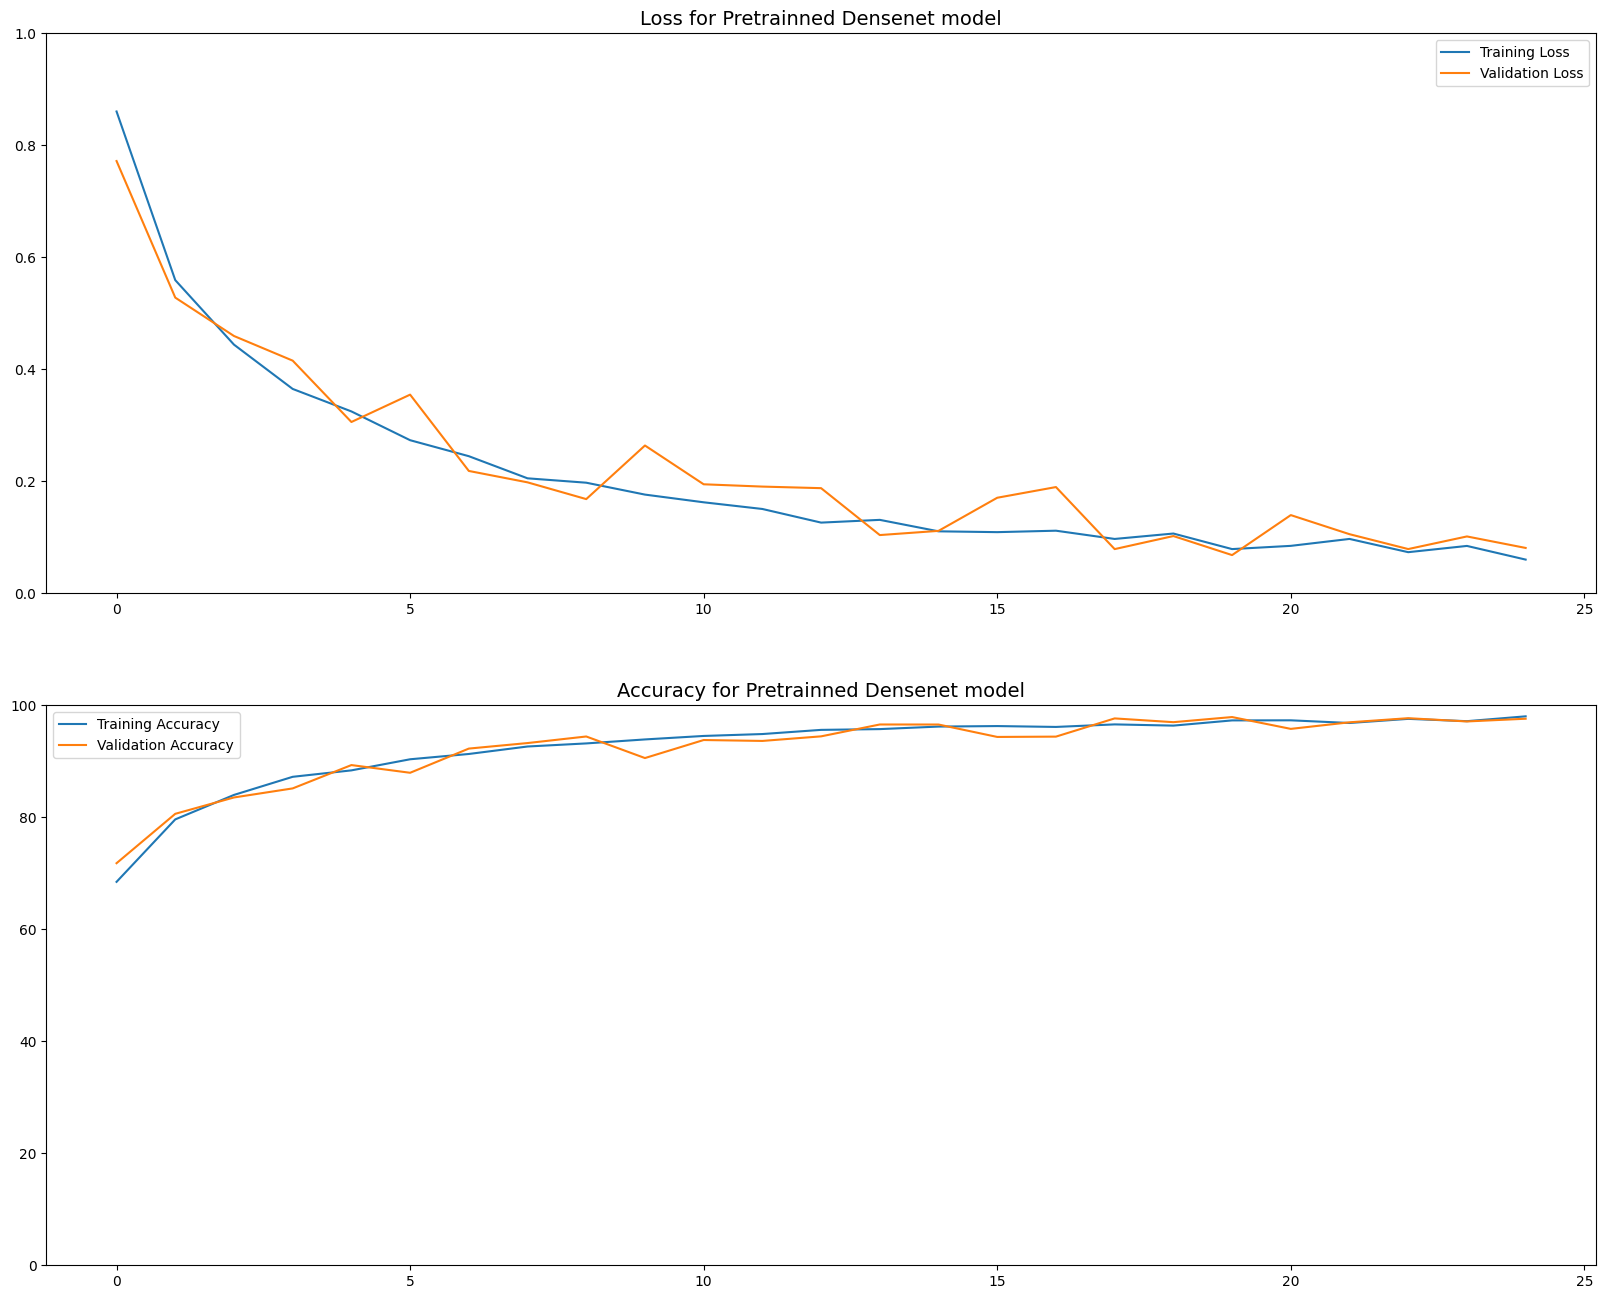

In [17]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)  
fig2.legend()
plt.show()

In [18]:
best_model_state = torch.load('densenet_pret.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 97.92913767998705
-------------------------------------------------------


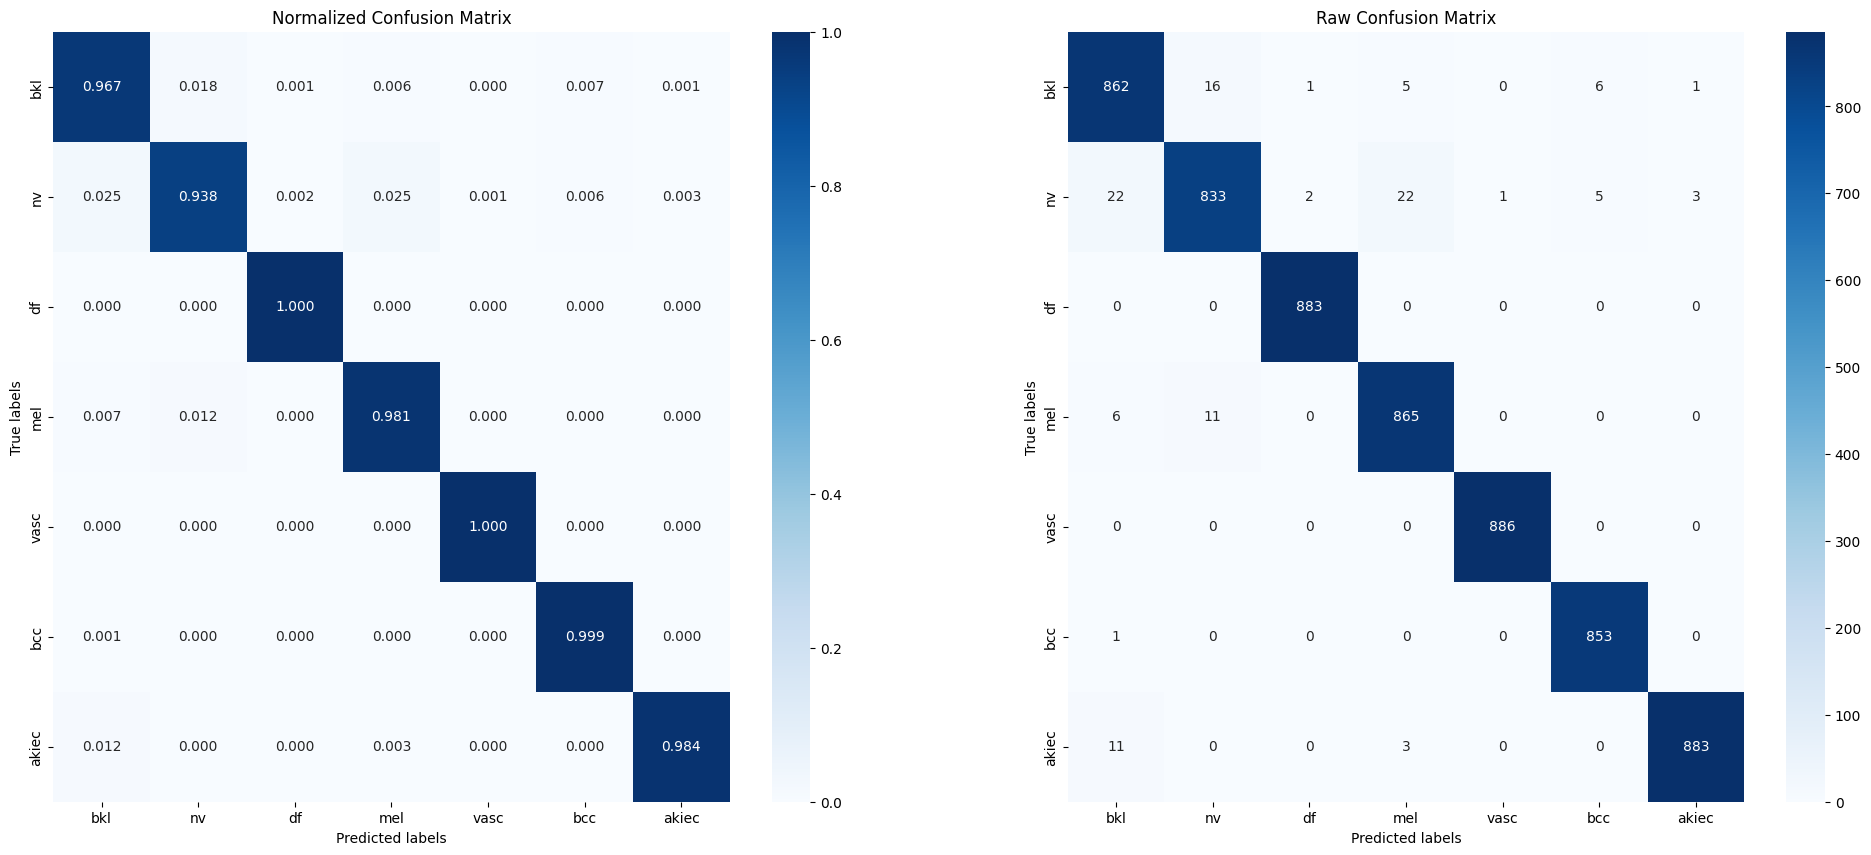

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.96      0.97      0.96       891
          nv       0.97      0.94      0.95       888
          df       1.00      1.00      1.00       883
         mel       0.97      0.98      0.97       882
        vasc       1.00      1.00      1.00       886
         bcc       0.99      1.00      0.99       854
       akiec       1.00      0.98      0.99       897

    accuracy                           0.98      6181
   macro avg       0.98      0.98      0.98      6181
weighted avg       0.98      0.98      0.98      6181

-------------------------------------------------------


In [19]:
Model_functions.conf_report(model_des, test_loader, 'densenet_conf_mat')